# Ethereum Return Prediction and the Knowledge of When to Strike

## Business Question and Approach

The tasks:
    
    1.) inspect what indicators to build a percentage 5 day return model with
    
    2.) find a good preditive model
    
    3.) find a characterisation for the indicators state to find out when to buy/strike
    
    4.) evaluate 1.), 2.), and 3.) through visualizations

## Ingestion of Data

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import talib
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale, Normalizer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor as rfr
from xgboost import XGBRegressor as xgb

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
import pandas_datareader as pdr
import datetime 

In [4]:
btci = pdr.get_data_yahoo('ETH-USD', 
                          start=datetime.datetime(2017, 7, 1), 
                          end=datetime.datetime(2020, 7, 1))


## Exploration of Data

In [5]:
btci.describe()

,High,Low,Open,Close,Volume,Adj Close
count,1098.000000,1098.000000,1098.000000,1098.000000,1.098000e+03,1098.000000
mean,324.174912,300.918346,313.358083,313.216159,5.733514e+09,313.216159
std,241.402089,216.161983,229.938924,229.804999,5.446461e+09,229.804999
min,85.342743,82.829887,84.279694,84.308296,2.537470e+08,84.308296
25%,175.608868,167.007423,171.416668,171.493206,1.669748e+09,171.493206
50%,230.685997,217.901024,225.522499,225.488968,3.562880e+09,225.488968
75%,349.157753,329.213249,338.629990,338.475494,8.085190e+09,338.475494
max,1432.880005,1290.599976,1397.479980,1396.420044,2.808919e+10,1396.420044


In [6]:
btci.head(10)


,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2017-06-30,293.747986,268.617004,293.352997,274.601013,1089200000,274.601013
2017-07-01,295.509003,262.519989,275.122986,287.987000,1123330048,287.987000
2017-07-02,291.104004,281.175995,288.414001,282.898010,851408000,282.898010
2017-07-03,287.388000,273.110992,282.191010,273.303009,687691008,273.303009
2017-07-04,275.125000,261.446991,273.098999,268.773987,790256000,268.773987
2017-07-05,278.476013,265.511993,268.858002,270.549011,623080000,270.549011
2017-07-06,273.942993,244.173996,270.350006,245.990997,687251968,245.990997
2017-07-07,273.476990,236.550995,245.889999,251.697006,754958016,251.697006
2017-07-08,255.104996,242.136993,251.822006,242.136993,505118016,242.136993


## Creating Indicators and targets from data

In [7]:

bx = btci.iloc[:,5].values.astype(float)
tx = btci.iloc[:,1].values.astype(float)
cx = btci.iloc[:,2].values.astype(float)
bix = btci.iloc[:,4].values.astype(float)

### the indicators


In [8]:
 #create bbands indicators
btci["upperband"], btci["middleband"], btci["lowerband"] = talib.BBANDS(bx, timeperiod=33, nbdevup=2, nbdevdn=2, matype=0)

#create the SMA indicator
btci['max' + str(7)] = talib.SMA(bx,timeperiod=7) / bx

feature_names = []  # a list of the feature names for 

# Create moving averages and rsi for timeperiods of 14, 30, 50, and 200
for n in [33]:
    # Create the RSI indicator
    btci['rsix' + str(n)] = talib.RSI(bx, timeperiod=n)
    
    # Create the CCI indicator
    btci['ccix' + str(n)] = talib.CCI(tx,cx,bx, timeperiod=n)
    
    # Create the MFI indicator
    btci['mfix' + str(n)] = talib.MFI(tx , cx, bx, bix, timeperiod=n)
    
   
    
    # Add rsi and moving average to the feature name list
    feature_names = feature_names + ['max' + str(n), 'rsix' + str(n)
                                     , 'ccix' + str(n), 'mfix' + str(n)]

print(feature_names)

['max33', 'rsix33', 'ccix33', 'mfix33']


### the target (cumulative percentage 5 day return)

In [9]:
btci['5cum_pct']=(1+btci['Close'].pct_change(-5).diff(periods=1)).cumprod()


In [10]:
btci.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1098 entries, 2017-06-30 to 2020-07-01
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   High        1098 non-null   float64
 1   Low         1098 non-null   float64
 2   Open        1098 non-null   float64
 3   Close       1098 non-null   float64
 4   Volume      1098 non-null   int64  
 5   Adj Close   1098 non-null   float64
 6   upperband   1066 non-null   float64
 7   middleband  1066 non-null   float64
 8   lowerband   1066 non-null   float64
 9   max7        1092 non-null   float64
 10  rsix33      1065 non-null   float64
 11  ccix33      1066 non-null   float64
 12  mfix33      1065 non-null   float64
 13  5cum_pct    1092 non-null   float64
dtypes: float64(13), int64(1)
memory usage: 128.7 KB


## Evaluating indicators with target

In [11]:
corr = btci.corr()


<function matplotlib.pyplot.show>

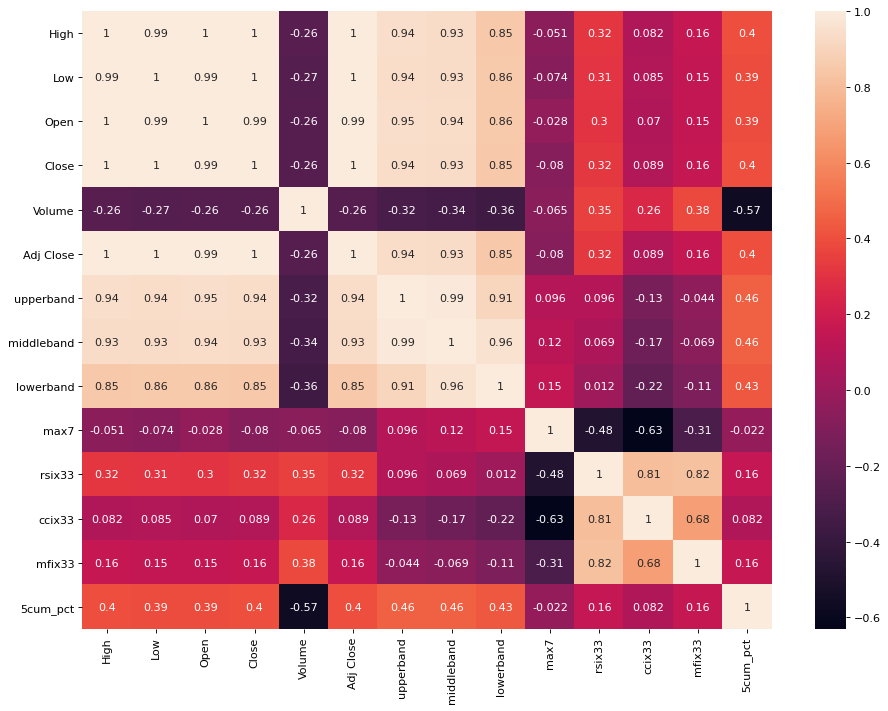

In [12]:

plt.figure(num=None, figsize=(12, 9), dpi=80, facecolor='w', edgecolor='k')
sns.heatmap(corr, annot=True)
plt.yticks(rotation=0); plt.xticks(rotation=90)  # fix ticklabel directions
plt.tight_layout()  # fits plot area to the plot, "tightly"
plt.show  # show the plot

## Building and none visual evaluations of models

### train test split of series data

In [13]:

con=btci.shape[0]
con60=con-60

X_train = scale(btci.iloc[201:con60,:13].values)
X_test = scale(btci.iloc[(con60-1):con,:13].values)[:56,:]

y_train = btci.iloc[201:con60,-1].values
y_test = btci.iloc[(con60-1):con,-1].values[:56]

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:173: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:173: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


### Linear model

In [14]:
lm_model = LinearRegression()

In [15]:
lm_model.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [16]:
pred = lm_model.predict(X_test)

In [17]:
print(lm_model.score(X_train,y_train))

0.8859023416337208


In [18]:
print(lm_model.score(X_test,y_test))

-35748.19216418012


### SVM model

In [19]:
sv_model = SVR(kernel='linear')

In [20]:
sv_model.fit(X_train,y_train)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [21]:
predsv = sv_model.predict(X_test)

In [22]:
print(sv_model.score(X_test,y_test))

-39652.9235009217


### KNN model

In [23]:
kn_model = KNeighborsRegressor(n_neighbors=7)

In [24]:
kn_model.fit(X_train,y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=7, p=2,
                    weights='uniform')

In [25]:
predkn = kn_model.predict(X_test)

In [26]:
predkntr = kn_model.predict(X_train)

In [27]:
print(kn_model.score(X_test,y_test))

-33534.94603770505


### RandomForest model

In [28]:
R=rfr()
R.fit(X_test,y_test)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [29]:
print(R.score(X_test,y_test))

0.9094058762752921


In [30]:
predr=R.predict(X_test)
print(mean_squared_error(y_test,predr))

7.154826389104092e-08


### XGBoost model

In [31]:
X=xgb()
X.fit(X_train,y_train)

[16:51:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [32]:
predx=X.predict(X_test)

In [33]:
print(X.score(X_test,y_test))

-37146.231021711785


#### the randomforest model is th most superior!

## Building representations for each state in time

#### we do this by clustering the indicators in 5 theoretical states:
    -- mono
    -- up
    -- up steep
    -- down
    -- down steep

In [99]:
X_trai=np.asmatrix((np.log2(y_train),X_train[:,6],X_train[:,7],X_train[:,8]))
X_tes=np.asmatrix(((y_test),X_test[:,6],X_test[:,7],X_test[:,8]))

In [100]:
from sklearn.cluster import KMeans

In [101]:
kmeans = KMeans(n_clusters=4) # You want cluster the passenger records into 2: Survived or Not survived
kmeans.fit(X_trai.T)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [102]:
predclutr=kmeans.predict(X_trai.T)

In [103]:
X_trai.shape,X_tes.shape

((4, 837), (4, 56))

In [104]:
predclu=kmeans.predict(X_tes.T)

## Visual Evaluation

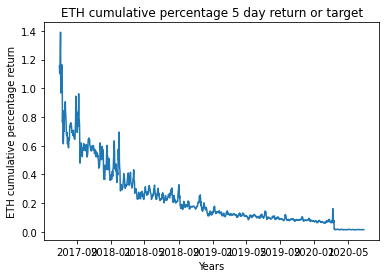

In [105]:
plt.plot(btci['5cum_pct'].dropna())
plt.title('ETH cumulative percentage 5 day return or target')
plt.xlabel('Years')
plt.ylabel('ETH cumulative percentage return')
plt.show()

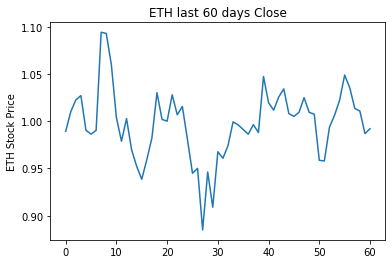

In [106]:
plt.plot(btci.iloc[con60-1:,9].values)
plt.title('ETH last 60 days Close')
plt.ylabel('ETH Stock Price')
plt.show()

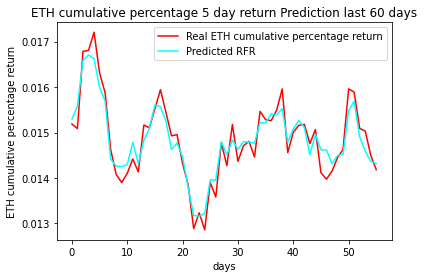

In [107]:
# Visualising the results

plt.plot(y_test, color = 'red', label = 'Real ETH cumulative percentage return')
#plt.plot(predx, color = 'blue', label = 'Predicted XGB')
#plt.plot(predkn, color = 'green', label = 'Predicted KNN')
plt.plot(predr, color = 'cyan', label = 'Predicted RFR')
plt.title('ETH cumulative percentage 5 day return Prediction last 60 days')
plt.xlabel('days')
plt.ylabel('ETH cumulative percentage return')
plt.legend()
plt.show()

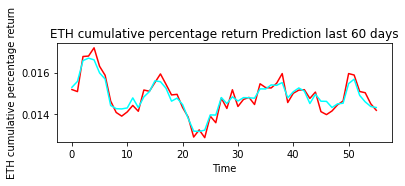

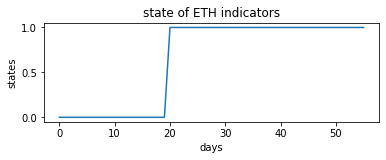

In [108]:
# Visualising the results
plt.figure()
plt.subplot(2,1,1)
plt.plot(y_test, color = 'red', label = 'Real ETH Stock Price')
plt.plot(predr, color = 'cyan', label = 'Predicted RFR')
plt.title('ETH cumulative percentage return Prediction last 60 days')
plt.xlabel('Time')
plt.ylabel('ETH cumulative percentage return')
plt.show()
plt.subplot(2,1,2)
plt.plot(predclu)
plt.title('state of ETH indicators')
plt.xlabel('days')
plt.ylabel('states')
plt.show()

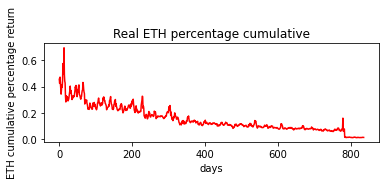

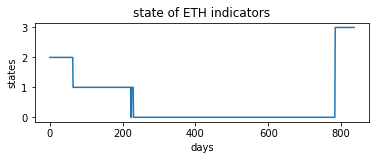

In [109]:
plt.figure()
plt.subplot(2,1,1)
plt.plot(y_train, color = 'red', label = 'Real ETH cumulative percentage return')
plt.title('Real ETH percentage cumulative')
plt.xlabel('days')
plt.ylabel('ETH cumulative percentage return')
#plt.ylim(.06,.12)
#plt.xlim(500,450)
plt.show()

plt.subplot(2,1,2)
plt.plot(predclutr)
plt.title('state of ETH indicators')
#plt.xlim(500,450)
plt.xlabel('days')
plt.ylabel('states')
plt.show()

#### what we can see from these graphs is how the randomforest model did on unknown data, and that the state representations captured the rising trend or when to strike in "cumulative 5 days percentage return" although due the randomness of picking specific states. all in all one can call this whole exercise a success answering all our questions.